![Kickstarer](./images/kickstarter.png)

---
Imports
---

In [62]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [2]:
# Import the .csv files and concat them into one dataframe
original_dataframe = pd.concat(map(pd.read_csv, glob.glob('data/data-2/*.csv')))

In [3]:
# Set a working dataframe, so that we don't have to wait 10s it to import again if we want to start fresh
df = original_dataframe

---
EDA - Part 1
---

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 3791
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obj

In [5]:
df.isnull().sum()

backers_count                    0
blurb                            8
category                         0
converted_pledged_amount         0
country                          0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
friends                     208922
fx_rate                          0
goal                             0
id                               0
is_backing                  208922
is_starrable                     0
is_starred                  208922
launched_at                      0
location                       226
name                             0
permissions                 208922
photo                            0
pledged                          0
profile                          0
slug                             0
source_url          

In [6]:
# Only a very limited amount of suspended projects (drop), canceled projects will be treated as though they failed
df['state'].value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [7]:
# Check for duplicate projects and store them in a table
dups = df.groupby(df.id.tolist()).size().reset_index().rename(columns={0:'count'})
# Sum the final col of that table, and subtract the number of culprits:
dups['count'].sum() - dups.shape[0]

26958

---
Data Cleaning
---

In [8]:
# Drop features which will not be needed for further analysis
dropped_features = ['blurb', 'currency_symbol', 'backers_count', 'is_backing', 'permissions', 'is_starred', 'source_url',
                    'slug', 'name', 'static_usd_rate', 'profile', 'friends', 'spotlight', 'is_starrable', 'photo', 'pledged', 'usd_type',
                    'fx_rate', 'location', 'creator', 'currency_trailing_code','current_currency', 'created_at', 'urls']
df = df.drop(dropped_features, axis=1)

In [9]:
# Built array which contains live projects for later use 
array_live = ['live']
live_projects = df.loc[df['state'].isin(array_live)]

# Filter and concat. for target variable
array_notlive = ['successful', 'failed', 'canceled']
df = df.loc[df['state'].isin(array_notlive)]
df.replace('canceled','failed', inplace=True)
# Replace successful and failed entries
df.replace(['successful','failed'],[1,0], inplace=True)

In [10]:
# Sort dataframe by 'date_changed_at' so that we will keep the entry that was most recently updated
df.sort_values('state_changed_at')
# Remove duplicates
duplicates = df.duplicated(subset='id', keep='last')
df = df[~duplicates]

---
Feature Engineering
---

In [11]:
#Extract category names from long string in 'category' column
list = []
for i, j in df['category'].iteritems():
    try:
        found = re.search('slug":"(.+?)/', j).group(1)
        list.append(found)
    except AttributeError:
        pass

list_2 = []
for i, j in enumerate(list):
    try:
        found = re.search('(.+?)"', j).group(1)
        list_2.append(found)
    except AttributeError:
        pass

# Add the categories and delete the original cluttered category
df['categories'] = pd.Series(list_2)
df.drop('category', axis=1, inplace=True)

In [12]:
# Generate new column with readable timeformat
df['launched_at_new'] = pd.to_datetime(df['launched_at'], unit='s')
df['deadline_new'] = pd.to_datetime(df['deadline'], unit='s')
df['state_changed_at_new'] = pd.to_datetime(df['state_changed_at'], unit='s')

In [13]:
# Create new feature 'duration' that displays wheather the project timespan was more or less than 30 days
df = df.eval('duration = deadline - launched_at')
df['duration'] = ['over' if x > 2592000 else 'under' for x in df['duration']]

In [14]:
# Add new column 'time' that displays the time from project launch to project end
df.eval('time = state_changed_at_new - launched_at_new', inplace=True)

In [15]:
# Change dates to weekend(1) or weekday(0)
def change_time(dataframe, column_list):
    for column in column_list:
        dataframe[column] = [1 if x >= 6 else 0 for x in pd.to_datetime(dataframe[column], unit='s').dt.weekday]
    return dataframe

In [16]:
times_lst = ['launched_at', 'deadline', 'state_changed_at']
change_time(df, times_lst)

,converted_pledged_amount,country,currency,deadline,disable_communication,goal,id,launched_at,staff_pick,state,state_changed_at,usd_pledged,categories,launched_at_new,deadline_new,state_changed_at_new,duration,time
1,1950,US,USD,0,False,1000.0,928751314,0,False,1,0,1950.000000,photography,2017-08-10 17:00:59,2017-09-09 17:00:59,2017-09-09 17:00:59,under,30 days 00:00:00
2,22404,US,USD,0,False,15000.0,928014092,0,False,1,0,22404.000000,fashion,2013-05-13 05:03:15,2013-06-12 05:03:15,2013-06-12 05:03:15,under,30 days 00:00:00
3,165,GB,GBP,0,False,10000.0,596091328,0,False,0,0,165.384934,music,2017-01-12 18:22:56,2017-03-13 17:22:56,2017-03-13 17:22:56,over,59 days 23:00:00
4,2820,US,USD,0,False,2800.0,998516049,0,False,1,0,2820.000000,photography,2012-12-10 20:32:07,2013-01-09 20:32:07,2013-01-09 20:32:07,under,30 days 00:00:00
5,3725,US,USD,0,False,3500.0,1224600291,0,False,1,0,3725.000000,theater,2015-04-02 02:25:46,2015-05-02 02:25:46,2015-05-02 02:25:46,under,30 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,8924,US,USD,0,False,1500.0,1011591139,0,False,1,0,8924.000000,photography,2018-11-27 22:38:32,2018-12-12 04:45:00,2018-12-12 04:45:01,under,14 days 06:06:29
3788,5710,NL,EUR,0,False,5000.0,4607750,1,False,1,0,5575.830204,theater,2017-05-14 17:21:54,2017-06-19 22:00:00,2017-06-19 22:00:00,over,36 days 04:38:06
3789,2681,US,USD,0,False,2500.0,67097337,0,False,1,0,2681.000000,photography,2012-08-14 20:36:30,2012-09-17 03:59:00,2012-09-17 03:59:01,over,33 days 07:22:31
3790,5692,US,USD,0,False,5500.0,1031742546,0,False,1,0,5692.000000,theater,2015-03-21 13:26:15,2015-04-20 13:26:15,2015-04-20 13:26:19,under,30 days 00:00:04


---
EDA - Part 2
---

#### Misc.

In [63]:
# Standardize nummerical data: Goal
scaler = MinMaxScaler()
scaler.fit(df[['goal']])
df['goal'] = scaler.transform(df[['goal']])

In [64]:
# Standardize nummerical data: Converted Pledged amount // Kick later!
scaler = MinMaxScaler()
scaler.fit(df[['converted_pledged_amount']])
df['converted_pledged_amount'] = scaler.transform(df[['converted_pledged_amount']])

In [65]:
# Standardize nummerical data: Pledged Amount in USD
scaler = MinMaxScaler()
scaler.fit(df[['usd_pledged']])
df['usd_pledged'] = scaler.transform(df[['usd_pledged']])

In [66]:
df['goal'].max()

0.9999999999999999

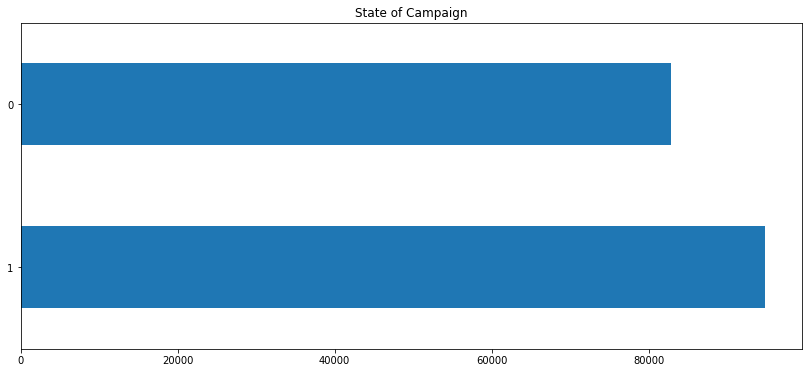

In [38]:

df['state'].value_counts().plot(kind = 'barh', figsize = (14,6))
plt.title('State of Campaign'); # 0 equals failed and 1 


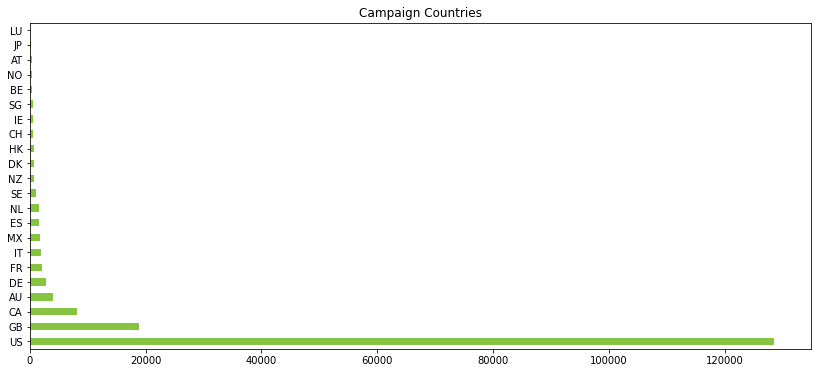

In [27]:
df['country'].value_counts().plot(kind = 'barh', figsize = (14,6), color = '#87c442')
plt.title('Campaign Countries');
# Mostly Campaigns from the US

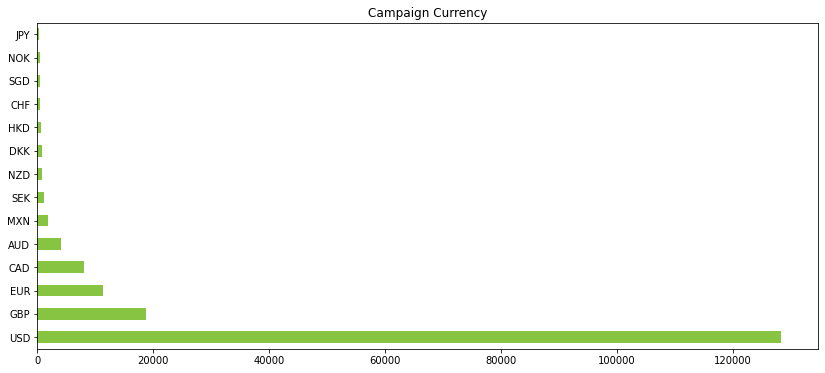

In [ ]:
df['currency'].value_counts().plot(kind = 'barh', figsize = (14,6), color = '#87c442')
plt.title('Campaign Currency');
# Mostly USD, corresponding to the high abundance of US American Campaigns

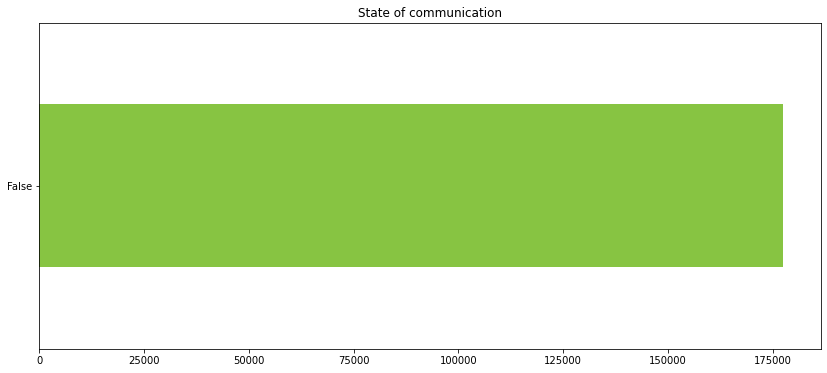

In [45]:
df['disable_communication'].value_counts().plot(kind = 'barh', figsize = (14,6), color = '#87c442')
plt.title('State of communication'); # 0 equals failed and 1 
# state of communication only false, can be disregarded

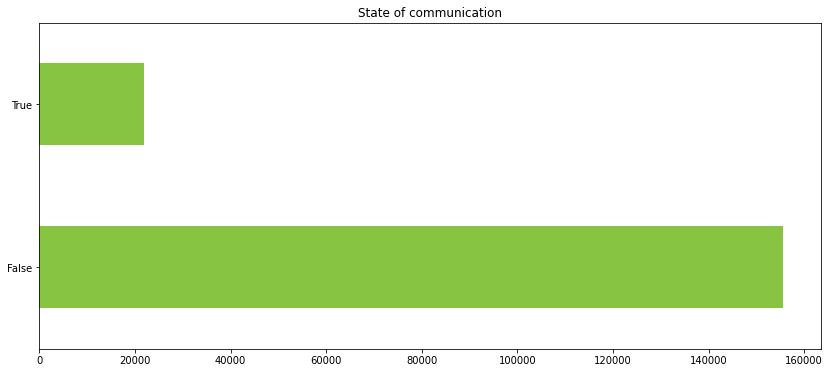

In [46]:
df['staff_pick'].value_counts().plot(kind = 'barh', figsize = (14,6), color = '#87c442')
plt.title('State of communication'); # 0 equals failed and 1 
# state of communication only false, can be disregarded

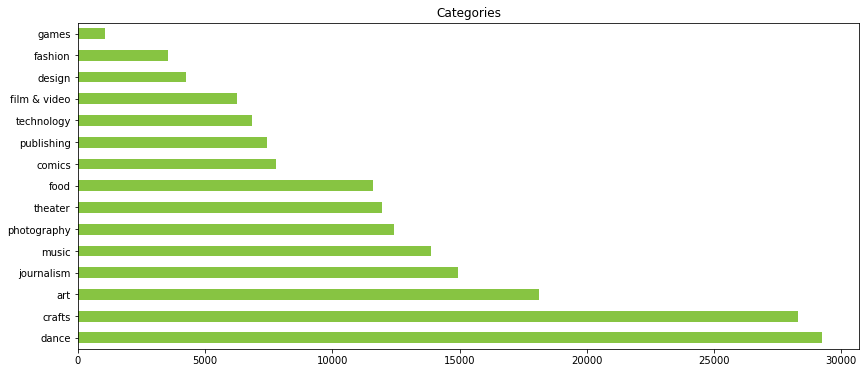

In [47]:
df['categories'].value_counts().plot(kind = 'barh', figsize = (14,6), color = '#87c442')
plt.title('Categories'); # 0 equals failed and 1 
# state of communication only false, can be disregarded

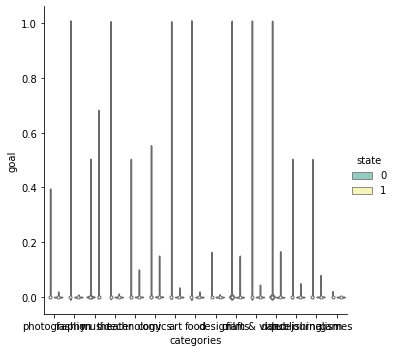

In [67]:
sns.catplot(data = df, x = 'categories', y = 'goal', hue = 'state', kind = 'violin', palette='Set3', bw=.2);
# goal need to be normalized

In [ ]:
# Drop id (not needed anymore)
df.drop('id', axis = 1, inplace = True)

#### One-hot encoding

In [ ]:
# One hot encode all categorical data (country, currency, staff_pick, categories, disable_communication, duration) boolean values might 
# need to be changed to 0,1 in column; includes: duration, disable_communication, staff_pick
one_hot_featurelist = ['country', 'currency', 'disable_communication', 'staff_pick', 'categories', 'duration']
one_hot = pd.get_dummies(df[one_hot_featurelist])
df.drop(one_hot_featurelist, axis = 1, inplace=True)
df = df.join(one_hot)